## Objective
Make a baseline model that predict the validation.



## Data Overview
File 1: estee-lauder.csv
* brand name: the id of the brand
* date: the date in a "y-m-d" format.
* discount: the info of the discount, sometimes XX% off, buy one get one free, gift with purchase (GWP), etc
* Comments_count: the number of people make comments of this deal.
* Bookmarks_count: the number of people saved the info this deal.
* Shares_count: the number of people shared this deal.

## EDA
### Load data

In [32]:
## Import modules:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data:
df_r = pd.read_csv("Data/Dealmoon/estee-lauder.csv")
df_r.drop(["Brand"], axis=1, inplace=True)
print(df_r.shape)
df_r.head()

(2729, 6)


,Store,Discount,Posted_date,Comments_count,Bookmarks_count,Shares_count
0,Estee Lauder,Free Gifts,2020-05-29,99.0,95.0,131.0
1,Estee Lauder,Free ANR Trio+Up to 6-pc Gifts,2020-05-26,93.0,93.0,57.0
2,Estee Lauder,20% Off + Free Gifts,2020-05-21,436.0,179.0,178.0
3,Estee Lauder,20% Off + Free Gifts,2020-05-21,15.0,26.0,23.0
4,Estee Lauder,BOGO + Up to 6-pc Gifts,2020-05-11,7042.0,1400.0,1081.0


## Simple discount processing
Look at the discount information first:

In [59]:
df_r['Discount'].value_counts()

15% Off                                                                                   177
Dealmoon Exclusive! Up to 5 free deluxe samples!                                          174
$62                                                                                        90
$45                                                                                        90
$39.5                                                                                      89
$110 + Gifts                                                                               89
$54                                                                                        89
$32                                                                                        88
15% Off One Online Order                                                                   88
$79+Free Gifts                                                                             88
Free 8-piece gift                                           

Just simply extracting the XX% off information first:

In [33]:
df_n = data_raw.copy()
df_n['Discount_off'] = df_n['Discount'].str.extract(r'(?P<discount>\d+)[%]')
df_n['Discount_off'] = df_n['Discount_off'].astype('float32')/100
df_n= df_n[df_n['Discount_off'].notna()]
print(df_n.shape)
df_n.head()

(361, 7)


,Store,Discount,Posted_date,Comments_count,Bookmarks_count,Shares_count,Discount_off
2,Estee Lauder,20% Off + Free Gifts,2020-05-21,436.0,179.0,178.0,0.2
3,Estee Lauder,20% Off + Free Gifts,2020-05-21,15.0,26.0,23.0,0.2
29,Estee Lauder,20% Off on $100 + Free Gifts,2019-12-14,1533.0,729.0,699.0,0.2
30,Estee Lauder,Up to 40% Off + Free Gifts,2019-12-12,19.0,57.0,52.0,0.4
31,Estee Lauder,Up to 40% Off,2019-12-03,60.0,94.0,64.0,0.4


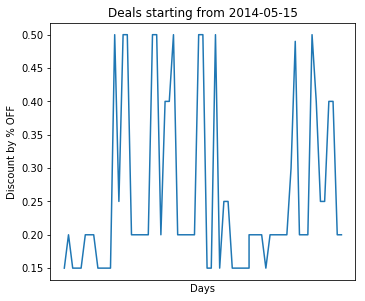

In [61]:
## Exploratory Visualization
# sort dataframe by date
df_n = df_n.sort_values(by=['Posted_date'])

fig = plt.figure(figsize=(14,8))
fig.set(alpha=0.5)
ax=plt.subplot2grid((2,3),(0,0))
plt.plot(df_n.Posted_date, df_n.Discount_off)
plt.xlabel(u"Days")
plt.xticks([])
plt.ylabel(u"Discount by % OFF")
plt.title(u"Deals starting from "+ str(df_n.Posted_date.min()))
plt.tight_layout()
plt.show()

From 2729 to 361 observations, seems lost a lot of data, and they don't always disrectly discount products. There are a lot of time they are offering gift with purchase (GWP) or GWP plus percentage off, so clustering them into another category:

In [62]:
#df_n['Discount_GWP'] = []
#for 
#df_n['Discount_off'] = df_n['Discount_off'].astype('float32')/100
#df_n= df_n[df_n['Discount_off'].notna()]

In [64]:
from pandas.tseries.holiday import USFederalHolidayCalendar as holidays
def get_holidays(yearrange = None):
    """
    Get the pd.DataFrame containing all the holidays date and names for the given years
    Parameters:
    -----------
    yearrange: list of years to be included in the result
    
    Returns:
    --------
    pd.DataFrame of holidays' date and names
    """
    if yearrange is None:
        return None
    
    holidaydict = {"date": [], "name": []}
    for date, name in holidays.US(years=yearrange).items():
        if "Observed" in name:
            continue
        holidaydict["date"].append(date)
        holidaydict["name"].append(name.replace(',', '').replace('\'','').replace('.','').replace(' ', '_'))
        #print(date, name)
    pd_holiday = pd.DataFrame(holidaydict)
    pd_holiday["date"] = pd.to_datetime(pd_holiday["date"])
    return pd_holiday

In [66]:
# consider holidays from year before and year after, because the closest holiday may not in the
# same year as the date under consideration
hyearrange=range(2010, 2020)
print("holiday year range:", hyearrange)
pd_holiday = get_holidays(hyearrange)
print(pd_holiday.head())
holidayset = set([h for h in pd_holiday["name"]])
print(holidayset)

holiday year range: range(2010, 2020)


AttributeError: type object 'USFederalHolidayCalendar' has no attribute 'US'

In [ ]:
data_clean = data_clean_dict
print("Brand:%s"%brand)
data_feature = features(data_clean)
data_feature_holiday = data_feature[["Date"]].copy()
for h in holidayset:
    print("holiday: %s"%h)
    data_feature_holiday["nday_away_"+h] = \
    data_feature_holiday.apply(lambda row: ndays_from_holiday(pd_holiday, h, row["Date"]), axis=1)  
#print(data_feature_holiday.head())
data_feature_holiday["nday_away_anyholiday"] = \
data_feature_holiday[["nday_away_"+h for h in holidayset]].max(axis=1)
data_feature_update = pd.concat([data_feature, data_feature_holiday.drop(["Date"], axis=1)], axis=1)
data_feature_update.drop(["ndays_of_deal"], axis=1, inplace=True)
data_feature.dropna(inplace=True)
fileoutname = input_filefolder+"/"+brand+"_features.csv"
data_feature_update.to_csv(fileoutname)
print("Saved:%s\n"%fileoutname)
#print(data_feature_update.head())
#print(len(data_feature_update.columns), data_feature_update.columns)